In [1]:
import pandas as pd
import numpy as np

In [2]:
dataset = pd.read_csv("IMDB-Dataset.csv")
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
# Preprocessing
dataset.drop_duplicates(keep='first', inplace=True)

In [5]:
dataset.shape

(49582, 2)

In [6]:
# Split
feature = dataset['review']
target = dataset['sentiment']

In [7]:
# Encoding target
labels = {
    "negative": 0, "positive" : 1
}
target = target.replace(labels).to_numpy()

C:\Users\prate\AppData\Local\Temp\ipykernel_24892\2537773637.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target = target.replace(labels).to_numpy()


### Text Processing


In [8]:
import re

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

eng_swords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [9]:
def text_processing(text):
    text = text.lower()

    text = re.sub(r"http\S+","", text) # urls
    text = re.sub(r"<.*?>", " ", text) # html tags
    text = re.sub(r"[\uD800-\uDBFF]|[\u2702-\u27B0]|[\uF680-\uF6C0]|[\u24C2-\uF251]","", text) # emoji
    text = re.sub(r"[^\w\s]","", text)

    text = [word for word in text.split() if word not in eng_swords]
    text = " ".join(text)

    text = lemmatizer.lemmatize(text)

    return text

In [10]:
cleaned_feature = feature.apply(text_processing).to_numpy()

In [14]:
# Visualization

!pip install wordcloud

  Using cached wordcloud-1.9.4-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
Using cached wordcloud-1.9.4-cp311-cp311-win_amd64.whl (299 kB)



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


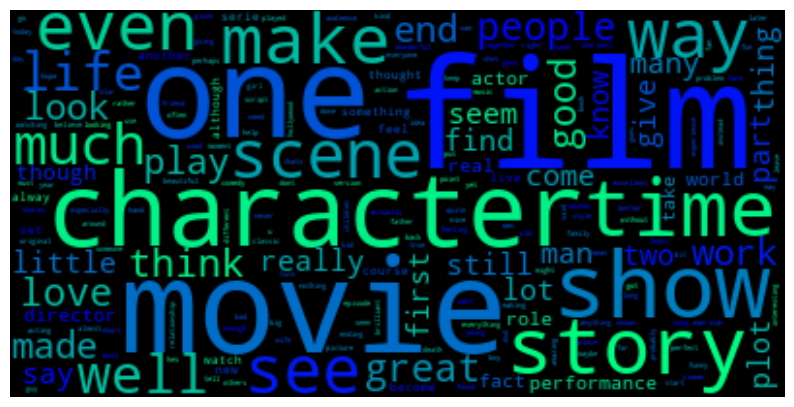

In [18]:
from wordcloud import WordCloud

pos_reviews = cleaned_feature[target == 1]

wordcloud = WordCloud(
    colormap="winter", background_color='black',contour_width=2, contour_color='#00ff80'
).generate(" ".join(pos_reviews))

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [19]:
# Word Vectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(cleaned_feature)


# from transformers import BertTokenizer, BertModel
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')
# tokens = tokenizer(text = list(cleaned_feature), return_tensors='pt', padding = True)
# embeddigs = model(**tokens).last_hidden_state

In [20]:
# splitting
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, stratify=target, shuffle=True, random_state=99)

In [21]:
# Apply Logistic Regression 
log_reg = LogisticRegression(n_jobs=-1, random_state=99)
log_reg.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=99)

In [22]:
log_reg.score(X_test, y_test)

0.9000705858626601

In [23]:
y_pred =log_reg.predict(X_test)

In [24]:
from sklearn.metrics import confusion_matrix, f1_score

print("F1 Score:", f1_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

F1 Score: 0.9015204213455232


array([[4390,  550],
       [ 441, 4536]], dtype=int64)

## Prediction or Inference

In [25]:
user_input = """I enjoyed the songs, but they didn't capture my attention the way Encanto's did. The story was a bit dull and all 
over the place. I tried to keep expectations low, and while I liked it, I didn't love it like I did Raya and the last dragon, Encanto, 
or the other recent Disney films. I feel maybe they spent too much time giving nods to classic films, rather than making the story more 
interesting.The style was ok, but I agree it looked like early 2000's dreamworks. Not 2D enough like Princess and the frog, and not 3D 
enough like the more recent films.Ralph Breaks the Internet was a better nod to classic Disney than this film. """

In [26]:
def pred_pipeline(input_text, model, vectorizer):
    processed = text_processing(input_text)

    embeddings = vectorizer.transform([processed])

    predict = model.predict(embeddings)

    return predict[0]

In [27]:
pred_pipeline(user_input, log_reg, tfidf)

1